In [1]:
from sklearn.linear_model import LinearRegression
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib as mpl
import datetime as dt
import pandas as pd
import numpy as np
import os

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 9
mpl.rcParams["axes.titlesize"] = 9
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 8
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
ALL_DIR = os.path.join(ROOT_DIR, "data", "All.csv")


In [2]:

# ########################################################## Plot Transience v. Novelty ##########################################################

# # Formato Eixos
# ax = fig.add_axes([0, 0.19, 0.4, 0.72])  # Dist do Y, Dist do X, largura, altura do grafico

# # Formato Cbar
# cbaxes = fig.add_axes([0.4, 0.29, 0.025, 0.5])  # Dist do Y, Dist do X, largura, altura da cbar

# # Colunas
# quants = ["Novelty", "Transience"]

# # Quadrados (bins)
# xbins = np.linspace(0, 10, 50)
# ybins = np.linspace(0, 10, 50)

# ## Gerando gráfico
# H, cbar = plot_quants_2Dhist(quants, source, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=cbaxes, cbar_orientation="vertical")

# # Titulo
# ax.set_title(f"{name} (n = {n})", x=0.5, y=1)

# # Colorbar
# cbar.ax.set_ylabel("")  # Sem label no Y
# cbar.ax.set_xlabel("")  # Sem label no X
# cbar.ax.yaxis.set_ticks_position("right")  # Posicaoo ticks
# cbar.ax.tick_params(labelsize=10)

# # Linha X=Y
# ax.plot([0, 10], [0, 10], color="k", linewidth=1.5, linestyle=":")

# # Legenda
# # ax.legend([mpl.lines.Line2D([0], [0], color="k", linewidth=1.5, linestyle="--")], ["x=y"], loc="upper center", fontsize=8, ncol=2, handlelength=2.7)

# # Eixo X
# ax.set_xlabel("Novelty $\mathcal{N}$")
# ax.set_xlim(2, 11.5)  # Escala do eixo X
# ax.set_xticks([2, 4, 6, 8, 10])  # Numeros de interesse eixo
# ax.xaxis.set_ticks_position("bottom")  # Ticks embaixo
# ax.spines["bottom"].set_bounds(2, 10)  # Delimita eixo
# ax.spines["top"].set_visible(False)  # Oculta eixo superior

# # Eixo Y
# ax.set_ylabel("Transience $\mathcal{T}$")
# ax.set_ylim(2, 11.5)  # Escala do eixo Y
# ax.set_yticks([4, 6, 8, 10])  # Numeros de interesse eixo
# ax.yaxis.set_ticks_position("left")  # Ticks na esquerda
# ax.spines["left"].set_bounds(2, 10)  # Delimita eixo
# ax.spines["right"].set_visible(False)  # Oculta eixo direito
# ax.tick_params(labelsize=11)

In [3]:
def plot_quants_2Dhist(quants, DATA_NTR, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=False, cbar_orientation="vertical", colorvmax=None):

    q0 = DATA_NTR[quants[0]]  # ["Novelty", "Resonance"][0]
    q1 = DATA_NTR[quants[1]]

    q0bins = xbins
    q1bins = ybins

    H, xedges, yedges = np.histogram2d(q0.to_numpy(), q1.to_numpy(), bins=[q0bins, q1bins])

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)

    # Mask zeros
    Hmasked = np.ma.masked_where(H == 0, H)  # Mask pixels with a value

    # Plot 2D histogram using pcolor
    if colorvmax:
        usemax = colorvmax
    else:
        usemax = H.max()
    pcolm = ax.pcolormesh(xedges, yedges, Hmasked, norm=mpl.colors.LogNorm(vmin=1, vmax=usemax))

    if make_cbar:
        if cbar_axis:
            cbar = fig.colorbar(pcolm, cax=cbar_axis, orientation=cbar_orientation)
        else:
            cbar = fig.colorbar(pcolm, ax=ax, orientation=cbar_orientation)
        cbar.ax.set_ylabel("counts")

    ax.set_xlabel(quants[0])
    ax.set_ylabel(quants[1])

    if make_cbar:
        return H, cbar
    else:
        return H

def tvn_plot(source, name, n):

    fig = plt.figure(figsize=(4.5, 2.5))

    ########################################################## Plot Resonance v. Novelty ##########################################################

    # Formato Eixos
    ax = fig.add_axes([0.7, 0.19, 0.35, 0.65])  # Dist do Y, Dist do X, largura, altura do grafico

    # Formato Cbar
    cbaxes = fig.add_axes([1.1, 0.29, 0.025, 0.5])  # Dist do Y, Dist do X, largura, altura da cbar

    # Colunas
    quants = ["Novelty", "Resonance"]

    # Regressão
    X = source[quants[0]].values.reshape(-1, 1)
    y = source[quants[1]].values.reshape(-1, 1)
    regressor = LinearRegression()
    regressor.fit(X, y)
    y_pred = regressor.predict(X)
    slope = regressor.coef_[0][0]
    ax.plot(X, y_pred, color='firebrick', linewidth=1.)
    ax.annotate(f'β = {slope:.3f}', xy=(112, 118), xycoords='axes points',
            size=8, ha='right', va='top', bbox=dict(boxstyle='square', fc='w',linewidth=0.5))

    # Quadrados (bins)
    xbins = np.linspace(3, 10, 50)  # Range dos quadrados em X, larguras
    ybins = np.linspace(-2, 2, 50)  # Range dos quadrados em Y, alturas

    ## Gerando gráfico
    H, cbar = plot_quants_2Dhist(quants, source, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=cbaxes, cbar_orientation="vertical")

    # Titulo
    ax.set_title(f"{name} (n = {n})", x=0.5, y=1.05)

    # Linha pontilhada
    #ax.axhline(color="k", linewidth=1.5, linestyle=":")

    # Colorbar
    cbar.ax.set_ylabel("")  # Sem label no Y
    cbar.ax.set_xlabel("")  # Sem label no X
    cbar.ax.yaxis.set_ticks_position("right")  # Posicao ticks
    cbar.ax.tick_params(labelsize=8)  # Tamanho numeros ticks

    # Eixo X
    ax.set_xlabel("Novelty ($\mathcal{N}$)")
    ax.set_xlim(3, 10)  # Escala do eixo X
    ax.set_xticks([3, 4, 5, 6, 7, 8, 9, 10])  # Numeros de interesse eixo
    ax.xaxis.set_ticks_position("bottom")  # Ticks embaixo
    ax.spines["bottom"].set_bounds(3, 10)  # Delimita eixo
    ax.spines["top"].set_visible(False)  # Oculta eixo superior

    # Eixo Y
    ax.set_ylabel("Resonance ($\mathcal{R}}$)")
    ax.set_ylim(-2, 2)  # Escala do eixo Y
    ax.set_yticks([-2, -1, 0, 1, 2])  # Numeros de interesse eixo
    ax.yaxis.set_ticks_position("left")  # Ticks na esquerda
    ax.spines["left"].set_bounds(-2, 2)  # Delimita eixo
    ax.spines["right"].set_visible(False)  # Oculta eixo direito

    return fig


/var/folders/xd/g9cbpcws3m14495hf_1bxjyh0000gn/T/ipykernel_87488/862148446.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4.5, 2.5))


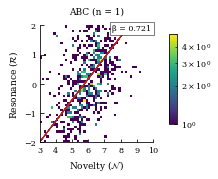

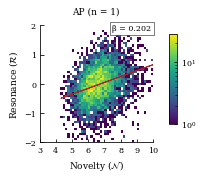

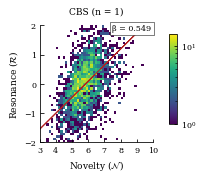

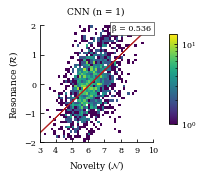

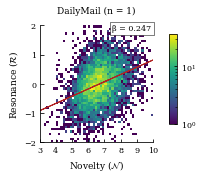

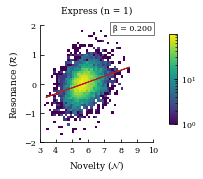

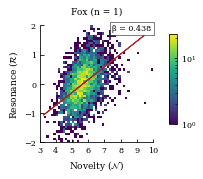

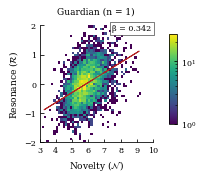

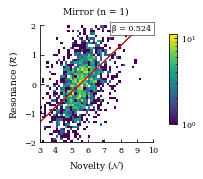

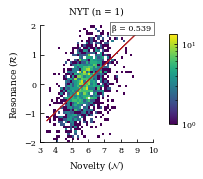

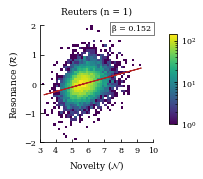

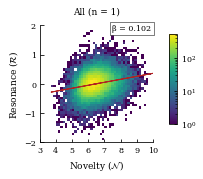

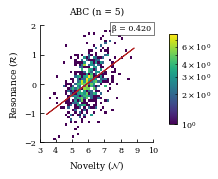

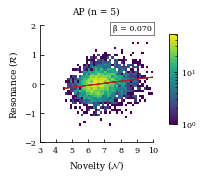

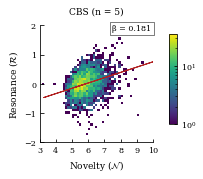

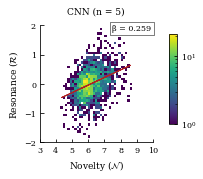

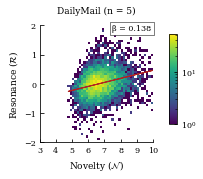

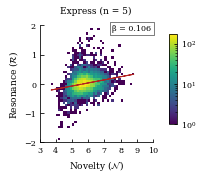

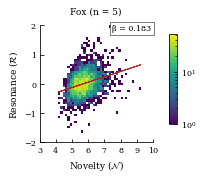

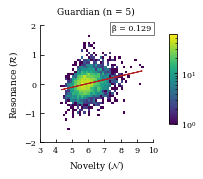

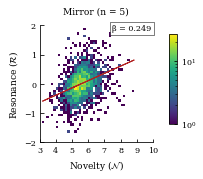

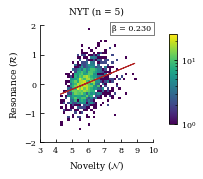

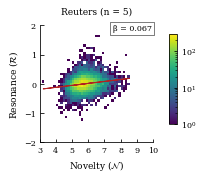

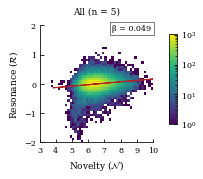

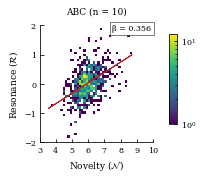

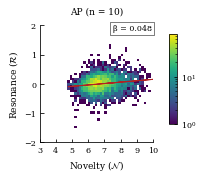

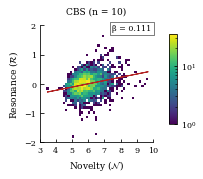

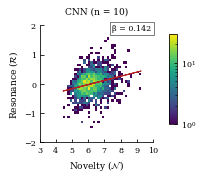

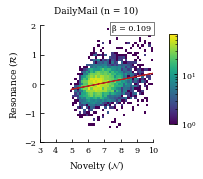

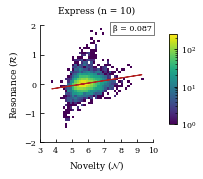

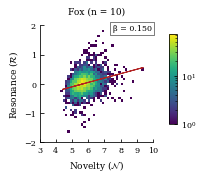

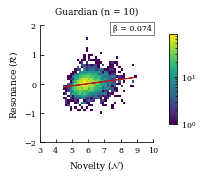

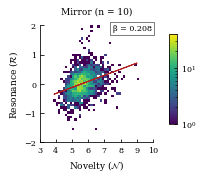

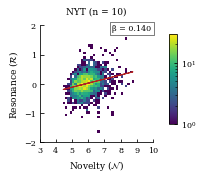

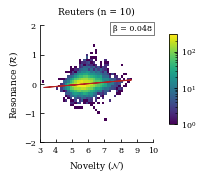

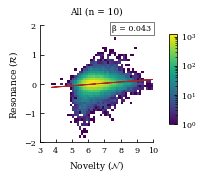

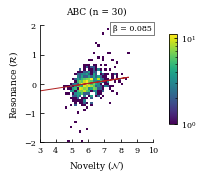

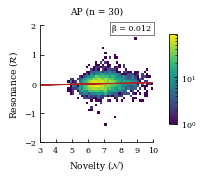

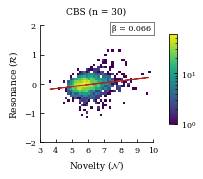

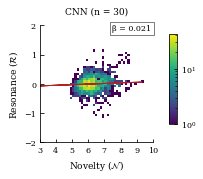

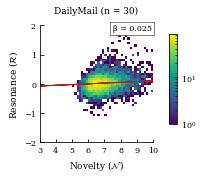

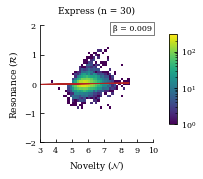

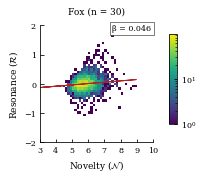

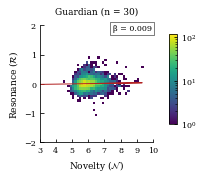

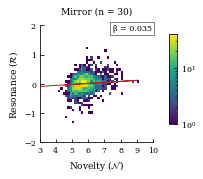

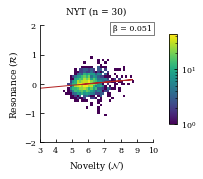

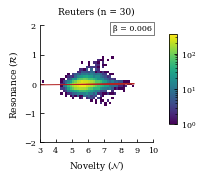

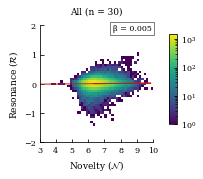

In [4]:
sources = [
    "ABC",
    "AP",
    "CBS",
    "CNN",
    "DailyMail",
    "Express",
    "Fox",
    "Guardian",
    "Mirror",
    "NYT",
    "Reuters",
    "All",
    ]

windows = [1,5,10,30]
for window in windows:
    for source in sources:
        data_df = pd.read_csv(os.path.join(ROOT_DIR, f"results_{window}", source + "_Results.csv"), parse_dates=["Date"], index_col=["Date"])
        ntr_df = data_df[["Novelty", "Transience", "Resonance"]].loc["03-01-2022":"12-01-2022"].copy()
        fig = tvn_plot(ntr_df, source, window)
        fig.savefig(os.path.join(ROOT_DIR, "figures", "2dhist", source + f"_TvN_{window}.svg"), format="svg", dpi=1000, bbox_inches="tight")
    